# Deep Q Learning to Play Space Invaders

In [1]:
# Import packages
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque
import random
import time

from tensorflow.keras.models import Sequential
import tensorflow as tf
print(tf.__version__)

from skimage import transform 
from skimage.color import rgb2gray 

1.15.0


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6786692642468030841
]


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## [1] Create the environment

In [11]:
# Create our environment
env = gym.make("SpaceInvaders-v0")

# Get state and action space
state_size = env.observation_space
action_size = env.action_space.n

print("The size of our frame is: ", state_size)
print("The action size is : ", action_size)

The size of our frame is:  Box(210, 160, 3)
The action size is :  6


## [2] Preprocess Functions

In [12]:
# plotting the images in a list
def plot_frames(display_list, title_list = None):
    
    plt.figure(figsize=(10, 10))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1) 
        
        if title_list:
            plt.title(title_list[i])
        plt.imshow(display_list[i])
        plt.axis('off')

    plt.show()

### [2.1] Image Filtering

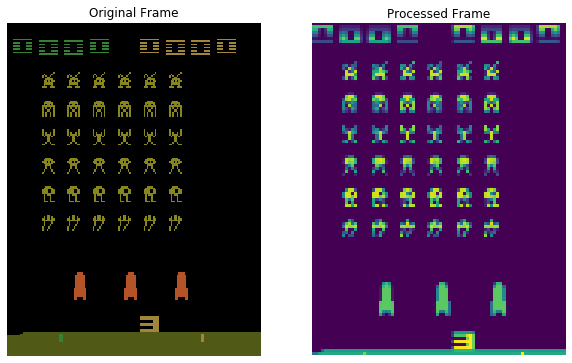

Size before process:  (210, 160, 3)
Size after process:  (110, 84)


In [13]:
# Normalise, turn into greyscale and crop image
frame_size = (110, 84)
def preprocess_frame(frame):
    # Greyscale frame 
    gray = rgb2gray(frame)
    
    # Crop the screen (remove the part below the player)
    # [Up: Down, Left: right]
    cropped_frame = gray[8:-12,4:-12]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    # Thanks to Mikołaj Walkowiak
    preprocessed_frame = transform.resize(normalized_frame, frame_size)
    
    return preprocessed_frame # 110x84x1 frame

# Test out the preprocess procedure
sample_state = env.reset()
sample_state_processed = preprocess_frame(sample_state)
plot_frames([sample_state, sample_state_processed], ['Original Frame','Processed Frame'])

print('Size before process: ', sample_state.shape)
print('Size after process: ', sample_state_processed.shape)

### [2.2] Stack the frames

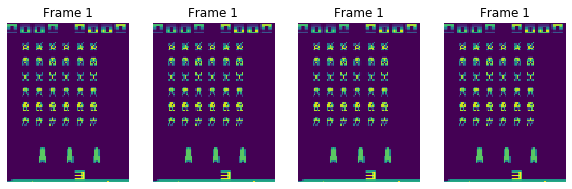

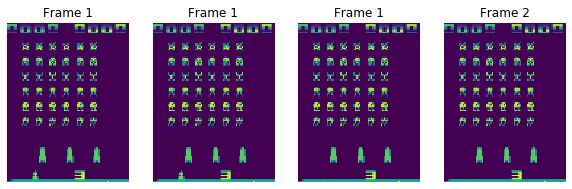

In [14]:
# Given a stacked frame, append a new frame to this stack
def stack_frames(stacked_frames, new_frame, is_new_episode):
    
    # Preprocess frame before stacking
    frame = preprocess_frame(new_frame)
    
    # if new episode make copies of frame, else append frame
    if is_new_episode:
        
        # Clear stacked frames
        stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)
        
        # Append the same frame to the stack stack_size times
        for _ in range(0, stack_size):
            stacked_frames.append(frame)
        
        # Return a numpy array for the stacked frame
        stacked_states = np.stack(stacked_frames, axis = 2)
    
    else:
        stacked_frames.append(frame)
        stacked_states = np.stack(stacked_frames, axis = 2)
    
    return stacked_states, stacked_frames

# Stacking frames to provide input = [frame 1, frame 2, frame 3, frame 4]
stack_size = 4

# Initialise with array of zeros
stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)

# Test out the stack_frames procedure
sample_state = env.reset()
stacked_states, stacked_frames = stack_frames(stacked_frames, sample_state, True)
plot_frames(stacked_frames, ['Frame ' + str(1) for i in range(0,4)])

for i in range(0, 4):
    sample_next_state, _ , done , _  = env.step(env.action_space.sample())
    stacked_states, stacked_frames = stack_frames(stacked_frames, sample_next_state, False)
    
plot_frames(stacked_frames, ['Frame ' + str(1) for i in range(1,4)] + ['Frame 2'] )

## 3 Training 

In [15]:
# Define paramters for training 
LEARNING_RATE = 0.001
MEMORY_SIZE = 30000
BATCH_SIZE = 64
MAX_STEP = 50000
UPDATE_MODEL_STEP = 5000

EXPLORATION_RATE = 1
EXPLORATION_DECAY = 0.9999
EXPLORATION_MIN = 0.01

GAMMA = 0.9

### [3.1] Create Deep Q Neural Network

In [16]:
class DQNetworks:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            # [None, 84, 84, 4]
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, self.action_size], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            self.mean_target = tf.reduce_mean(self.target_Q)
            
            # Input the Importance sampling weights here
            self.IS_weights = tf.placeholder(tf.float32, [None], name="IS_weights")
            
            """
            First convnet:
            CNN
            ELU
            """
            # Input is 110x84x4
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                         filters = 32,
                                         kernel_size = [8,8],
                                         strides = [4,4],
                                         padding = "VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv1")
            with tf.variable_scope('conv1', reuse=True):
                self.conv1w = tf.get_variable('kernel')
                self.conv1b = tf.get_variable('bias')
                
            self.conv1_out = tf.nn.elu(self.conv1, name="conv1_out")

                
            """
            Second convnet:
            CNN
            ELU
            """
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                 filters = 64,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv2")
            
            with tf.variable_scope('conv2', reuse=True):
                self.conv2w = tf.get_variable('kernel')
                self.conv2b = tf.get_variable('bias')
                

            self.conv2_out = tf.nn.elu(self.conv2, name="conv2_out")            
            
            """
            Third convnet:
            CNN
            ELU
            """
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                 filters = 64,
                                 kernel_size = [3,3],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv3")
            
            with tf.variable_scope('conv3', reuse=True):
                self.conv3w = tf.get_variable('kernel')
                self.conv3b = tf.get_variable('bias')

            self.conv3_out = tf.nn.elu(self.conv3, name="conv3_out")
            
            self.flatten = tf.contrib.layers.flatten(self.conv3_out)
            
            ## Here to separate into two streams
            # The one to calculate V(s)
            self.value_fc = tf.layers.dense(inputs = self.flatten,
                                            units = 512,
                                            activation = tf.nn.elu,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                            name="value_fc")
            
            with tf.variable_scope('value_fc', reuse=True):
                self.value_fcw = tf.get_variable('kernel')
                self.value_fcb = tf.get_variable('bias')
                
            self.value =  tf.layers.dense(inputs = self.value_fc,
                                          units = 1,
                                          activation = None,
                                          kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          name="value")
            
            # The one to calculate A(s,a)
            self.advantage_fc = tf.layers.dense(inputs = self.flatten,
                                                units = 512,
                                                activation = tf.nn.elu,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                                name="advantage_fc")
            
            with tf.variable_scope('advantage_fc', reuse=True):
                self.advantage_fcw = tf.get_variable('kernel')
                self.advantage_fcb = tf.get_variable('bias')
            
            self.advantage = tf.layers.dense(inputs = self.advantage_fc, 
                                             kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                             units = self.action_size, 
                                             activation=None,
                                             name = "advantage")
            
            
            # Agregating layer 
            self.output = tf.add(self.value, tf.subtract(self.advantage, tf.reduce_mean(self.advantage, axis=1, keepdims=True)))
            
            self.max_Q_pred = tf.reduce_max(self.output, axis = 1)
            self.max_Q_mean_pred = tf.reduce_mean(self.max_Q_pred)
            self.argmax_Q_pred = tf.argmax(self.output, axis = 1)
            
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_), axis = -1)      
        
            
            # Absolute errors for Priortising
            self.abs_TD_error = tf.abs(self.target_Q - self.Q)
            
            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(self.IS_weights * tf.square(self.abs_TD_error))
            
            self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)

In [17]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DQNetworks([110, 84, 4], action_size, LEARNING_RATE, "DQN")

# Instantiate the TargetDQNetwork
TargetDQNetwork = DQNetworks([110, 84, 4], action_size, LEARNING_RATE, "TargetDQN")

In [18]:
# Setup TensorBoard Writer
!rm -rf ./tensorboard/dddqn/1
writer = tf.summary.FileWriter("./tensorboard/dddqn/1")

tf.summary.scalar("Loss", DQNetwork.loss)
tf.summary.scalar("Mean_Target", DQNetwork.mean_target)
tf.summary.scalar("Mean_Predict", DQNetwork.max_Q_mean_pred)
tf.summary.histogram("Conv1/Weights", DQNetwork.conv1w)
tf.summary.histogram("Conv1/Bias", DQNetwork.conv1b)
tf.summary.histogram("Conv1/Activation", DQNetwork.conv1_out)
tf.summary.histogram("Conv2/Weights", DQNetwork.conv2w)
tf.summary.histogram("Conv2/Bias", DQNetwork.conv2b)
tf.summary.histogram("Conv2/Activation", DQNetwork.conv2_out)
tf.summary.histogram("Conv3/Weights", DQNetwork.conv3w)
tf.summary.histogram("Conv3/Bias", DQNetwork.conv3b)
tf.summary.histogram("Conv3/Activation", DQNetwork.conv3_out)
tf.summary.histogram("Value/Weights", DQNetwork.value_fcw)
tf.summary.histogram("Value/Bias", DQNetwork.value_fcb)
tf.summary.histogram("Advantage/Weights", DQNetwork.advantage_fcw)
tf.summary.histogram("Advantage/Bias", DQNetwork.advantage_fcb)
tf.summary.histogram("Q_values/Q_predict", DQNetwork.output)
tf.summary.histogram("Q_values/Q_target", DQNetwork.target_Q)
tf.summary.histogram("Q_values/Q_predict_max", DQNetwork.max_Q_pred)
tf.summary.histogram("Q_values/arg_Q_predict_max", DQNetwork.argmax_Q_pred)

## Losses
write_op = tf.summary.merge_all()

### [3.2] Create memory for experience relay

In [19]:
class SumTree:
    
    # Index for pointing to data 
    data_index = 0
    capacity_filled = 0
    
    # Initialise the tree and data
    def __init__(self, capacity):
        
        # The size of the leaves
        self.capacity = capacity
        
        # Define the tree list itself, zeros everywhere
        self.tree = np.zeros(capacity*2 - 1)
        
        # Define the data list for holding experiences, zeros everywhere
        self.data = np.zeros(capacity, dtype=object)
        
    # Add new values to tree
    def add(self, priority, data):
        
        # add to data list 
        self.data[self.data_index] = data
        
        # add the priority to the leaf of the tree
        tree_index = self.data_index + self.capacity - 1
        self.update(priority, tree_index)
        
        # Increase data_index
        self.data_index += 1
        if self.data_index > self.capacity - 1:
            self.data_index = 0
            
        # Inrease capacity filled
        if self.capacity_filled < self.capacity:
            self.capacity_filled += 1
            
    # Update all the nodes leading up to a leaf
    def update(self, priority, tree_index):
        
        # Find the change in priority value
        delta_priority = priority - self.tree[tree_index]
        
        # Update leaf
        self.tree[tree_index] = priority
        
        # Propagate change up
        while tree_index != 0 :
            tree_index = (tree_index - 1)//2
            self.tree[tree_index] += delta_priority 
            
    # sample a leaf from a value
    def get_leaf(self, value):
        
        # Define initial indixes
        parent_index = 0
        left_index = 1
        right_index = 2
        
        # Retrive the leaf algorithm
        while left_index < (2*self.capacity - 1):
            if self.tree[left_index] >= value: 
                parent_index = left_index
            else:
                parent_index = right_index
                value = value - self.tree[left_index]      
            # Update left_index for next iteration
            left_index = parent_index*2 + 1
            right_index = left_index + 1
            
        return parent_index, self.tree[parent_index], self.data[parent_index + 1 - self.capacity]

In [20]:
class Memory():
    
    # Max TD error
    abs_error_upper = 1.0;
    
    # Prioritzation exponents
    PER_a = 0.6
    PER_b = 0.4
    epsilon= 0.01
    
    # Incremental value for PER_b
    PER_b_increments = 0.001
    
    def __init__(self, capacity):
        
        # Create the sum tree
        self.memory_tree = SumTree(capacity)
            
    def store(self, experience):
        
        # Get the max priority so far
        max_priority = np.max(self.memory_tree.tree[-self.memory_tree.capacity:])
        
        # if max prioity is 0 then set it as abs_error_upper
        if max_priority == 0:
            max_priority = self.abs_error_upper
        
        # Store this experience in the tree
        self.memory_tree.add(max_priority, experience)
        
        
    def sample(self, n):
        
        # Get total priority
        total_priority = self.memory_tree.tree[0]
        
        # Sample from a mini range [0:total_priority] in batch sizes
        sample_ranges = np.linspace(0, total_priority, num=n+1)
        
        # get min P(i) of data filled so far and max weight to scale maximum weights = 1
        start_filled = -self.memory_tree.capacity
        end_filled = -(self.memory_tree.capacity - self.memory_tree.capacity_filled)
        if  end_filled == 0:
            min_probability = np.min(self.memory_tree.tree[start_filled:])/total_priority
        else:
            min_probability = np.min(self.memory_tree.tree[start_filled:end_filled])/total_priority
        max_weight = (self.memory_tree.capacity_filled * min_probability) ** (-self.PER_b)
        
        # Initialise list for storing
        tree_indexes = np.empty(n, dtype=np.int32)
        IS_weights = np.empty(n, dtype=np.float32)
        batch = []
        
        # Sample in a loop
        for i in range(0, n):
            value = np.random.uniform(sample_ranges[i], sample_ranges[i+1])
            tree_index, priority, experience = self.memory_tree.get_leaf(value)
            
            # Append tree indicies of sample 
            tree_indexes[i] = tree_index
            
            # Obtain IS_weights
            sample_probability = (priority / total_priority)
            IS_weights[i] = ((self.memory_tree.capacity_filled * sample_probability) ** (-self.PER_b)) / max_weight
            
            # append expereice  to batch
            batch.append(experience)
            
        # Increase PER_b value for every sampling action max = 1
        if self.PER_b < 1.0:
            self.PER_b += self.PER_b_increments
        
        return tree_indexes, IS_weights, batch
            
            
    def update_batch(self, tree_indexes, TD_errors):
        priorities = np.minimum(self.abs_error_upper, (TD_errors + self.epsilon)) ** self.PER_a
        
        # update the batch of prrioties
        for idx, new_p in zip(tree_indexes, priorities):
            self.memory_tree.update(new_p, idx)

### [3.3] Act to exploit or explore

In [21]:
# Function to pick action either from model or take random action
def act(state, exploration_rate):
    
    # Take random action
    if np.random.rand() < exploration_rate:
        return env.action_space.sample()
    
    # Else use the model to predict a action
    q_values = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state[tf.newaxis,...]})
    
    return np.argmax(q_values[0])

In [22]:
# Update the target network 
def update_graph():
    
    # Get weights
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "DQN")
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "TargetDQN")
    
    # Update the target 
    updated_weights = [to_var.assign(from_var) for from_var, to_var in zip(from_vars, to_vars)]
    
    return updated_weights

## [3.4] Train agent in batches from memory

In [23]:
# Function to fit data from experience obtained from memory, THE LEARNING PROCEDURE
def train_model(BATCH_SIZE, step):
    
    # Sample from memory
    tree_idx, IS_weights, batch = memory.sample(BATCH_SIZE)
    
    # Extract each parameter from batch
    state_batch = np.zeros((BATCH_SIZE, 110, 84, 4))
    action_batch = np.zeros([BATCH_SIZE, action_size], dtype = int)
    reward_batch = np.zeros(BATCH_SIZE)
    state_next_batch = np.zeros((BATCH_SIZE, 110, 84, 4))
    done_batch = np.zeros(BATCH_SIZE)
    for i in range(0,len(batch)):
        state_batch[i] = batch[i][0]
        action_batch[i][batch[i][1]] = 1
        reward_batch[i] = batch[i][2]
        state_next_batch[i] = batch[i][3]
        done_batch[i] = batch[i][4]

    # Model predict the Q-values
    Q_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state_next_batch})
    Target_Q_next_state = sess.run(TargetDQNetwork.output, feed_dict = {TargetDQNetwork.inputs_: state_next_batch})

    # Calculate target Q
    target_Q_batch = np.zeros(BATCH_SIZE)
    for i in range(0, len(batch)):
        if done_batch[i]:
            target_Q_batch[i] = reward_batch[i]
        else:
            best_action = np.argmax(Q_next_state[i])
            target_Q_batch[i] = reward_batch[i] + GAMMA * Target_Q_next_state[i][best_action]

    
    # Fit the data 
    loss, abs_TD_error, _ = sess.run([DQNetwork.loss, DQNetwork.abs_TD_error, DQNetwork.optimizer],
                                            feed_dict={DQNetwork.inputs_: state_batch,
                                                    DQNetwork.target_Q: target_Q_batch,
                                                    DQNetwork.actions_: action_batch,
                                                    DQNetwork.IS_weights: IS_weights})
    
    # Update the priorites with latest TD errors
    memory.update_batch(tree_idx, abs_TD_error)
    
    # Write TF Summaries
    if step % 20 == 0:
        summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: state_batch,
                                                        DQNetwork.target_Q: target_Q_batch,
                                                        DQNetwork.actions_: action_batch,
                                                        DQNetwork.IS_weights: IS_weights})
        writer.add_summary(summary, step)
        writer.flush()

    return loss

### [3.5] Test agent by taking random actions

In [24]:
# Play a game to test environment 
def test(n_episodes, model = None, memory = None, render=False, clip_reward=True):
    
    # Initialise average rewards
    avg_rewards = 0
    run_list = []
    
    for i in range(1, n_episodes+1):
        
        # Initialise the start of environment
        state = env.reset()
        stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        done = False 
        total_reward = 0
        steps = 0
        
        # Play the environment until done
        while not done:
            if render:
                env.render()
                time.sleep(0.01)
            if model:
                action = np.argmax(sess.run(model.output, feed_dict = {model.inputs_: state[tf.newaxis,...]})[0])
            else:
                action = env.action_space.sample()
            state_next, reward, done, info = env.step(action)
            if clip_reward:
                reward = np.sign(reward)
            state_next, stacked_frames = stack_frames(stacked_frames, state_next, False)
            if memory:
                memory.store((state, action, reward, state_next, done))
            state = state_next
            total_reward += reward
            steps += 1
            if steps > MAX_STEP:
                done = True
                
        if render:
            env.close()
        
        # Store running average and run results
        avg_rewards = avg_rewards + 1/(i) * (total_reward - avg_rewards)
        run_list.append(steps)
        
    print("The average rewards for {} runs is {}".format(n_episodes, avg_rewards))
        
    return run_list, avg_rewards

In [100]:
sess = tf.Session()
sess.run(tf.global_variables_initializer()) 

# Define the training material
state_train = np.random.rand(2,110, 84, 4)
target_Q = np.random.rand(2)
action_list = np.array([[0,1,0,0,0,0], [0,0,0,0,1,0]])
IS_weights = np.array([0.1, 0.1])

  
loss, abs_error, weighted_TD = sess.run([DQNetwork.loss, DQNetwork.abs_TD_error, DQNetwork.weighted_TD], 
                                feed_dict = {DQNetwork.inputs_: stacked_states[tf.newaxis,...], 
                                             DQNetwork.target_Q: target_Q,
                                             DQNetwork.actions_: action_list,
                                             DQNetwork.IS_weights: IS_weights})


print(loss)
print(abs_error)
print(weighted_TD)

0.010286483
[0.11516771 0.43870953]
[0.01151677 0.04387095]


In [25]:
# Check time taken to train for 1 batch
memory = Memory(MEMORY_SIZE)
steps, total_reward = test(1, model = None, memory = memory)

The average rewards for 1 runs is 4.0


In [34]:
start_time = time.time()
with tf.Session() as sess:
    # Initialize the variables
    sess.run(tf.global_variables_initializer())
    history = train_model(BATCH_SIZE, 1)
print("Loss is :", history)
print("Elapsed_time: ", time.time() - start_time)

Loss is : 0.0050816573
Elapsed_time:  0.4747309684753418


### Training on the environment

In [18]:
# Re-Initialise memory for training
memory = Memory(MEMORY_SIZE)

# Run Tests and store initial memory
print("Start filling memory")
while memory.memory_tree.capacity_filled  < 10000:
    steps, total_reward = test(1, model = None, memory = memory)

print("Memory filled! The memory length is", memory.memory_tree.capacity_filled)

The average rewards for 1 runs is 14.0
The average rewards for 1 runs is 7.0
The average rewards for 1 runs is 8.0
The average rewards for 1 runs is 5.0
The average rewards for 1 runs is 17.0
The average rewards for 1 runs is 9.0
The average rewards for 1 runs is 7.0
The average rewards for 1 runs is 9.0
The average rewards for 1 runs is 15.0
The average rewards for 1 runs is 12.0
The average rewards for 1 runs is 7.0
The average rewards for 1 runs is 18.0
The average rewards for 1 runs is 10.0
The average rewards for 1 runs is 5.0
The average rewards for 1 runs is 12.0
Memory length:  10732


In [11]:
# Start the session
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())   

In [20]:
# Store measurements
loss = []
reward_list = []
step_list = []
total_steps = 0
start_time = time.time()

# Number of episodes to train 
N = 600
for i in range(0, N):

    # Initialise state
    state = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, state, True)
    reward_sum = 0

    # Initialise step oer episode
    step = 0
    done = False

    while not done:

        # Get action 
        action = act(state, EXPLORATION_RATE)

        # Take action
        state_next, reward, done, _ = env.step(action)
        reward = np.sign(reward)

        # Append the next state
        state_next, stacked_frames = stack_frames(stacked_frames, state_next, False)

        # Append to memory
        memory.store((state, action, reward, state_next, done))

        # Forward to next state
        state = state_next

        # accumulate rewards
        reward_sum += reward

        # accumilate steps
        step += 1
        total_steps += 1

        # stops the episode by set max step
        if step > MAX_STEP:
            done = True
            print("Episode Done")
                
        # Update model every UPDATE_STEP (5000)
        if total_steps % UPDATE_MODEL_STEP == 0:
            sess.run(update_graph())
            print("Target network updated!")
            
        ### Learning procedure begins ###
        if total_steps % 4 ==0:
            history = train_model(BATCH_SIZE, total_steps)
            loss.append(history)
            # Reduce the exploreation every step
            EXPLORATION_RATE *= EXPLORATION_DECAY
            EXPLORATION_RATE = max(EXPLORATION_MIN, EXPLORATION_RATE)            
        ### Learning procedure ends ###


    # Append values at the end of an episode
    step_list.append(step)
    reward_list.append(reward_sum)
#     test(1, model=DQNetwork)
    
    # print information at the end of the episode
    print("Episode {}, exploration rate: {:.4f}, final rewards: {}, final loss is {:.4f}, Time elapsed: {:.4f}"\
          .format(i+1, EXPLORATION_RATE, reward_sum, history, time.time() - start_time))
    start_time = time.time()

save_path = saver.save(sess, "./D3QN_PER_TF_model/model.ckpt")
print("Model Saved")

Target network updated!
Episode 1, exploration rate: 0.9373, final rewards: 9.0, final loss is 0.0161, Time elapsed: 27.7195
Episode 2, exploration rate: 0.8935, final rewards: 8.0, final loss is 0.0108, Time elapsed: 21.4735
Episode 3, exploration rate: 0.8278, final rewards: 13.0, final loss is 0.0082, Time elapsed: 35.0403
Episode 4, exploration rate: 0.7796, final rewards: 12.0, final loss is 0.0099, Time elapsed: 27.5989
Episode 5, exploration rate: 0.7486, final rewards: 5.0, final loss is 0.0107, Time elapsed: 18.8732
Episode 6, exploration rate: 0.7003, final rewards: 7.0, final loss is 0.0058, Time elapsed: 33.0120
Episode 7, exploration rate: 0.6613, final rewards: 9.0, final loss is 0.0061, Time elapsed: 26.6695
Episode 8, exploration rate: 0.6205, final rewards: 9.0, final loss is 0.0059, Time elapsed: 31.3929
Target network updated!
Episode 9, exploration rate: 0.5765, final rewards: 8.0, final loss is 0.0088, Time elapsed: 34.1582
Episode 10, exploration rate: 0.5314, fin

Episode 79, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0078, Time elapsed: 38.1699
Episode 80, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0060, Time elapsed: 20.2745
Episode 81, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0046, Time elapsed: 18.4507
Target network updated!
Episode 82, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0057, Time elapsed: 26.6240
Episode 83, exploration rate: 0.0100, final rewards: 13.0, final loss is 0.0050, Time elapsed: 34.1670
Episode 84, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0088, Time elapsed: 35.1068
Episode 85, exploration rate: 0.0100, final rewards: 22.0, final loss is 0.0063, Time elapsed: 50.4603
Episode 86, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0073, Time elapsed: 26.9042
Episode 87, exploration rate: 0.0100, final rewards: 19.0, final loss is 0.0054, Time elapsed: 45.5289
Episode 88, exploration rate: 0.0100, final rewards: 1

Episode 156, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0097, Time elapsed: 43.1779
Episode 157, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0059, Time elapsed: 29.6807
Episode 158, exploration rate: 0.0100, final rewards: 18.0, final loss is 0.0064, Time elapsed: 52.5310
Episode 159, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0016, Time elapsed: 30.5901
Episode 160, exploration rate: 0.0100, final rewards: 21.0, final loss is 0.0060, Time elapsed: 50.4593
Episode 161, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0074, Time elapsed: 32.8503
Target network updated!
Episode 162, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0065, Time elapsed: 36.9257
Episode 163, exploration rate: 0.0100, final rewards: 18.0, final loss is 0.0050, Time elapsed: 47.9985
Episode 164, exploration rate: 0.0100, final rewards: 26.0, final loss is 0.0049, Time elapsed: 80.5795
Episode 165, exploration rate: 0.0100, fina

Target network updated!
Episode 233, exploration rate: 0.0100, final rewards: 24.0, final loss is 0.0057, Time elapsed: 54.8080
Episode 234, exploration rate: 0.0100, final rewards: 3.0, final loss is 0.0040, Time elapsed: 19.4096
Episode 235, exploration rate: 0.0100, final rewards: 12.0, final loss is 0.0048, Time elapsed: 49.0958
Episode 236, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0035, Time elapsed: 43.4161
Episode 237, exploration rate: 0.0100, final rewards: 31.0, final loss is 0.0073, Time elapsed: 99.0766
Episode 238, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0043, Time elapsed: 26.2205
Target network updated!
Episode 239, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0053, Time elapsed: 37.8361
Episode 240, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0031, Time elapsed: 34.2446
Episode 241, exploration rate: 0.0100, final rewards: 25.0, final loss is 0.0090, Time elapsed: 60.2056
Episode 242, explora

Episode 310, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0048, Time elapsed: 25.2194
Target network updated!
Episode 311, exploration rate: 0.0100, final rewards: 14.0, final loss is 0.0087, Time elapsed: 50.0677
Episode 312, exploration rate: 0.0100, final rewards: 15.0, final loss is 0.0069, Time elapsed: 48.9688
Episode 313, exploration rate: 0.0100, final rewards: 21.0, final loss is 0.0056, Time elapsed: 57.3102
Episode 314, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0067, Time elapsed: 27.2598
Episode 315, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0078, Time elapsed: 27.8036
Episode 316, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0066, Time elapsed: 33.8961
Target network updated!
Episode 317, exploration rate: 0.0100, final rewards: 16.0, final loss is 0.0090, Time elapsed: 56.1582
Episode 318, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0040, Time elapsed: 39.1658
Episode 319, explora

Episode 387, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0026, Time elapsed: 27.0748
Episode 388, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0046, Time elapsed: 33.1615
Episode 389, exploration rate: 0.0100, final rewards: 15.0, final loss is 0.0025, Time elapsed: 59.6654
Target network updated!
Episode 390, exploration rate: 0.0100, final rewards: 20.0, final loss is 0.0063, Time elapsed: 59.8451
Episode 391, exploration rate: 0.0100, final rewards: 16.0, final loss is 0.0118, Time elapsed: 51.2074
Episode 392, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0025, Time elapsed: 38.0254
Episode 393, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0033, Time elapsed: 35.6201
Episode 394, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0042, Time elapsed: 33.9745
Episode 395, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0058, Time elapsed: 34.4199
Target network updated!
Episode 396, explorati

Episode 464, exploration rate: 0.0100, final rewards: 7.0, final loss is 0.0054, Time elapsed: 31.8401
Episode 465, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0041, Time elapsed: 30.3381
Episode 466, exploration rate: 0.0100, final rewards: 5.0, final loss is 0.0028, Time elapsed: 26.1214
Episode 467, exploration rate: 0.0100, final rewards: 15.0, final loss is 0.0087, Time elapsed: 42.4865
Episode 468, exploration rate: 0.0100, final rewards: 6.0, final loss is 0.0054, Time elapsed: 18.9530
Target network updated!
Episode 469, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0049, Time elapsed: 32.0641
Episode 470, exploration rate: 0.0100, final rewards: 2.0, final loss is 0.0080, Time elapsed: 18.2765
Episode 471, exploration rate: 0.0100, final rewards: 17.0, final loss is 0.0071, Time elapsed: 53.3996
Episode 472, exploration rate: 0.0100, final rewards: 8.0, final loss is 0.0067, Time elapsed: 31.7128
Episode 473, exploration rate: 0.0100, final re

Episode 541, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0036, Time elapsed: 24.9665
Episode 542, exploration rate: 0.0100, final rewards: 25.0, final loss is 0.0054, Time elapsed: 53.8835
Episode 543, exploration rate: 0.0100, final rewards: 16.0, final loss is 0.0039, Time elapsed: 47.3478
Target network updated!
Episode 544, exploration rate: 0.0100, final rewards: 16.0, final loss is 0.0053, Time elapsed: 52.9420
Episode 545, exploration rate: 0.0100, final rewards: 19.0, final loss is 0.0076, Time elapsed: 53.7510
Episode 546, exploration rate: 0.0100, final rewards: 17.0, final loss is 0.0068, Time elapsed: 61.4411
Episode 547, exploration rate: 0.0100, final rewards: 10.0, final loss is 0.0031, Time elapsed: 37.1376
Episode 548, exploration rate: 0.0100, final rewards: 9.0, final loss is 0.0060, Time elapsed: 43.1210
Episode 549, exploration rate: 0.0100, final rewards: 4.0, final loss is 0.0054, Time elapsed: 32.2666
Target network updated!
Episode 550, explor

In [26]:
test(1, model=DQNetwork, render=True, clip_reward=False)

The average rewards for 1 runs is 110.0


([669], 110.0)

Text(0.5, 0, 'Runs')

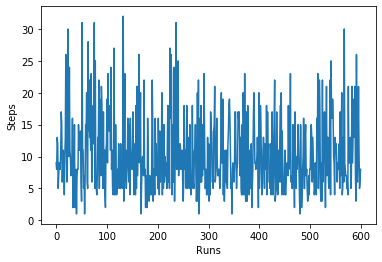

In [21]:
# plot result
plt.plot(reward_list)
plt.ylabel('Steps')
plt.xlabel('Runs')

Text(0.5, 0, 'Runs')

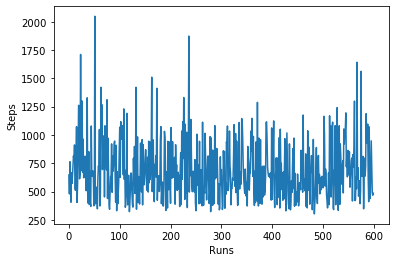

In [22]:
plt.plot(step_list)
plt.ylabel('Steps')
plt.xlabel('Runs')

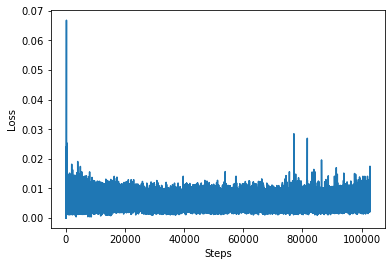

In [27]:
# plot loss
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('Steps')
plt.show()

In [ ]:
# For saving and loading files
saver = tf.train.Saver()

In [25]:
# Test the model and get average rewards
with tf.Session() as sess:
    
    # Load the model
    saver.restore(sess, "./D3QN_PER_TF_model/model.ckpt")
    
    # Run Tests
    N_tests = 20
    steps, total_reward = test(N_tests, model = DQNetwork, memory = None)
    
print("Average rewards over {} episodes is {}".format(N_tests, total_reward))

INFO:tensorflow:Restoring parameters from ./D3QN_PER_models/model.ckpt
Average rewards over 20 episodes is 175.49999999999997


In [22]:
with tf.Session() as sess:

    # Load the model
    saver.restore(sess, "./D3QN_PER_TF_model/model.ckpt")

    # Initialise environment 
    state = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, state, True)

    done = False 
    total_reward = 0
    steps = 0

    # Until done 
    while not done:

        # render the current environment 
        env.render()

        # take an action using model
        Q_values= sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state[tf.newaxis,...]})
        action = np.argmax(Q_values[0])
        next_state, reward, done, info = env.step(action)
        next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
        state = next_state

        total_reward += reward
        steps += 1

        # pause for visualisation
        time.sleep(0.01)

    env.close()
    print ("Score: {}, Steps: {}".format(total_reward, steps))

INFO:tensorflow:Restoring parameters from ./D3QN_PER_TF_model/model.ckpt
Score: 120.0, Steps: 653
